<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-Projects/blob/main/EuroSAT%20Satellite%20Image%20Classification/EuroSAT_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
%%markdown
# EuroSAT Satellite Image Classification using a CNN

* Author: Mohammadreza Mohammadi
* Date: 24-Aug-2025

## Description:
 This notebook provides a complete, end-to-end workflow for classifying
 the EuroSAT dataset. The process includes:
   1.  Setting up the environment and downloading the dataset.
   2.  Loading and preprocessing the data using TensorFlow's data pipeline.
   3.  Visualizing a sample of the dataset.
   4.  Building a robust Convolutional Neural Network (CNN) architecture.
   5.  Compiling and training the model.
   6.  Evaluating the model's performance with learning curves, a
       confusion matrix, and a classification report.

Dataset URL : https://zenodo.org/records/7711810#.ZAm3k-zMKEA

# EuroSAT Satellite Image Classification using a CNN

* Author: Mohammadreza Mohammadi
* Date: 24-Aug-2025

## Description:
 This notebook provides a complete, end-to-end workflow for classifying
 the EuroSAT dataset. The process includes:
   1.  Setting up the environment and downloading the dataset.
   2.  Loading and preprocessing the data using TensorFlow's data pipeline.
   3.  Visualizing a sample of the dataset.
   4.  Building a robust Convolutional Neural Network (CNN) architecture.
   5.  Compiling and training the model.
   6.  Evaluating the model's performance with learning curves, a
       confusion matrix, and a classification report.

Dataset URL : https://zenodo.org/records/7711810#.ZAm3k-zMKEA


# Import Libraries

In [2]:
import os
import zipfile
import numpy  as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load-in Dataset & Configuration

In [3]:
# Params
IMG_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 20
DATASET_URL = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"
DATASET_DIR = "EuroSAT"

In [4]:
# Download dataset
if not os.path.exists(DATASET_DIR):
    print("Downloading dataset...")
    # download and extract
    path_to_zip = tf.keras.utils.get_file(
        "EuroSAT.zip",
        origin=DATASET_URL,
        extract=True,
        cache_dir=".",
        archive_format="zip"
    )

    # Keras usally extacts data to ~/.keras/datasets/
    # the actual data is in subfolder
    # for simplicity, we assume the user moves the 2750 folder and renames it
    # to 'EuroSAT`
    # A more robust approach would be to handle the path properly
    # Manual Instruction:
    # download and unzip, then rename the parent image folder to 'EuroSAT'
    print(f"Dataset downloaded and extracted. Please ensure the main image folder is named '{DATASET_DIR}'.")
else:
    print("Dataset already exists.")

# the eurosat dataset from the zip is inside a folder
# named "2750". we will use this path.
DATA_PATH = os.path.join(os.path.dirname(path_to_zip), '2750')

94280567/94280567 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Dataset downloaded and extracted. Please ensure the main image folder is named 'EuroSAT'.


# Load & Preprocess Data

In [6]:
# We will use tf.keras.utils.image_dataset_from_directory which is
# highly efficeint for loading image data from directories
print("Loading and Splitting Data...")

train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="training",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=123
)

# Create the validation dataset
print("-" * 50)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="validation",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=123
)


Loading and Splitting Data...
Found 27000 files belonging to 10 classes.
Using 21600 files for training.
--------------------------------------------------
Found 27000 files belonging to 10 classes.
Using 5400 files for validation.


In [7]:
# Get class names from directory structure
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"Class Names: {class_names}")
print(f"Number of Classes: {num_classes}")

Class Names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Number of Classes: 10


# Exploratory Data Analysis

Visualizing a Sample of the Data....


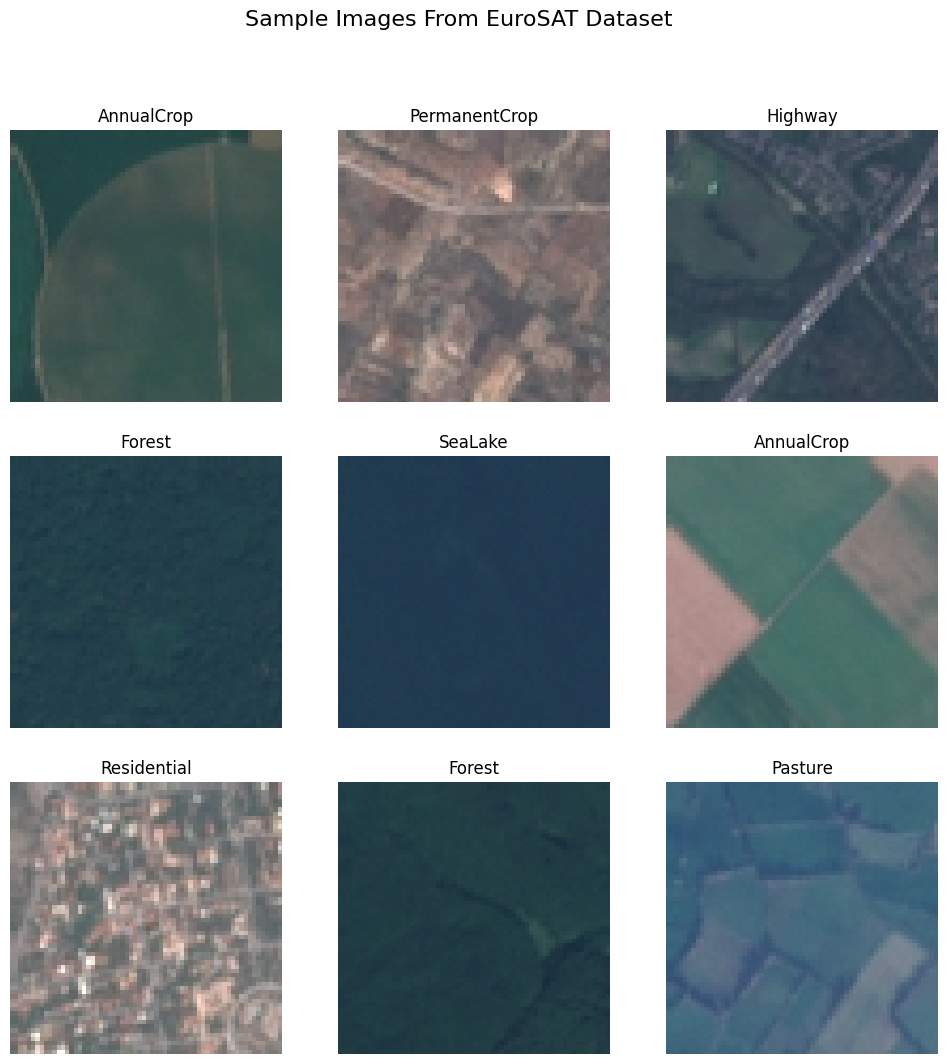

In [8]:
print("Visualizing a Sample of the Data....")
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Images From EuroSAT Dataset", fontsize=16)
plt.show()

# Configure Dataset for Performance

In [9]:
# Use caching and prefetching to optimize
# the data loading pipeling
# AUTOTUNE allows the TF runtime to dynamically determine
# the optimal number of parallel calls for operations
# like prefetching and shuffling
AUTOTUNE = tf.data.AUTOTUNE

# .cache() to caches the dataset elements in memory.
# .shuffle() shuffles the dataset with a buffer size of 1000
# .prefetch(buffer_size=AUTOTUNE) prefetches data while
# the model is training this overlaps the data loading and processing
# with model execution, preventing the CPU from being
# bottleneck.
# AUTOTUNE allows TF to determine the optimal number of elements
# to prefetch
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Model Definition

In [10]:
# Define data augmentation layers to prevent overfitting
print("Data Augmentation....")
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

print("\n\nBuilding the CNN Model....")
model = tf.keras.models.Sequential([
    # Input
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Augmentation layer
    data_augmentation,
    # Rescaling layer >> normlize pixel values from [0, 255] to [0, 1]
    tf.keras.layers.Rescaling(1./255),

    # Conv Block 1
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Conv block 2
    tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Conv block 3
    tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten the feature maps to feed into the dense layers
    tf.keras.layers.Flatten(),

    # Dense classifier head
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),

    # Output layer
    tf.keras.layers.Dense(num_classes, activation="softmax")])

# Compile the model
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Data Augmentation....


Building the CNN Model....


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,143,242 (4.36 MB)

 Trainable params: 1,143,242 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [11]:
print("Starting Model Training....")
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
)
print("Model Training Complete!")

Starting Model Training....
Epoch 1/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.3618 - loss: 1.7131 - val_accuracy: 0.5869 - val_loss: 1.1000
Epoch 2/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6203 - loss: 1.0727 - val_accuracy: 0.6557 - val_loss: 1.0014
Epoch 3/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6721 - loss: 0.9287 - val_accuracy: 0.7352 - val_loss: 0.7420
Epoch 4/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7023 - loss: 0.8554 - val_accuracy: 0.7685 - val_loss: 0.6543
Epoch 5/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7341 - loss: 0.7697 - val_accuracy: 0.7728 - val_loss: 0.6412
Epoch 6/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7607 - loss: 0.6925 - val_accuracy: 0.8156 - val_loss: 0.5215
Epoch 7/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7746 - loss: 0.6461 - val_accuracy: 0.8067 - val_loss: 0.5568
Epoch 8/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.787

# Evaluate Model

Plotting Learning Curves....


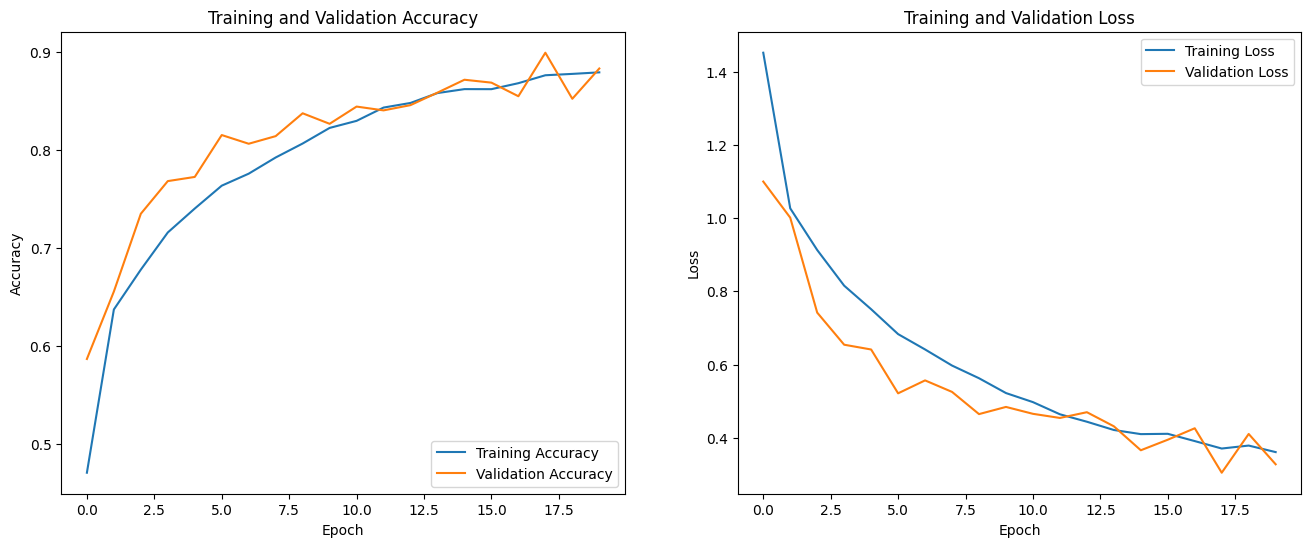

In [12]:
print("Plotting Learning Curves....")
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Losses
loss = history.history['loss']
val_loss = history.history['val_loss']

# Epochs
epochs_range = range(EPOCHS)


# Plotting
# Accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Losses
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Generate Predictions

In [13]:
# Generate predictions to create a confusion matrix and classification report
y_pred = []
y_true = []
for images, labels in validation_dataset:
    y_true.extend(labels.numpy())
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

Confusion Matrix..


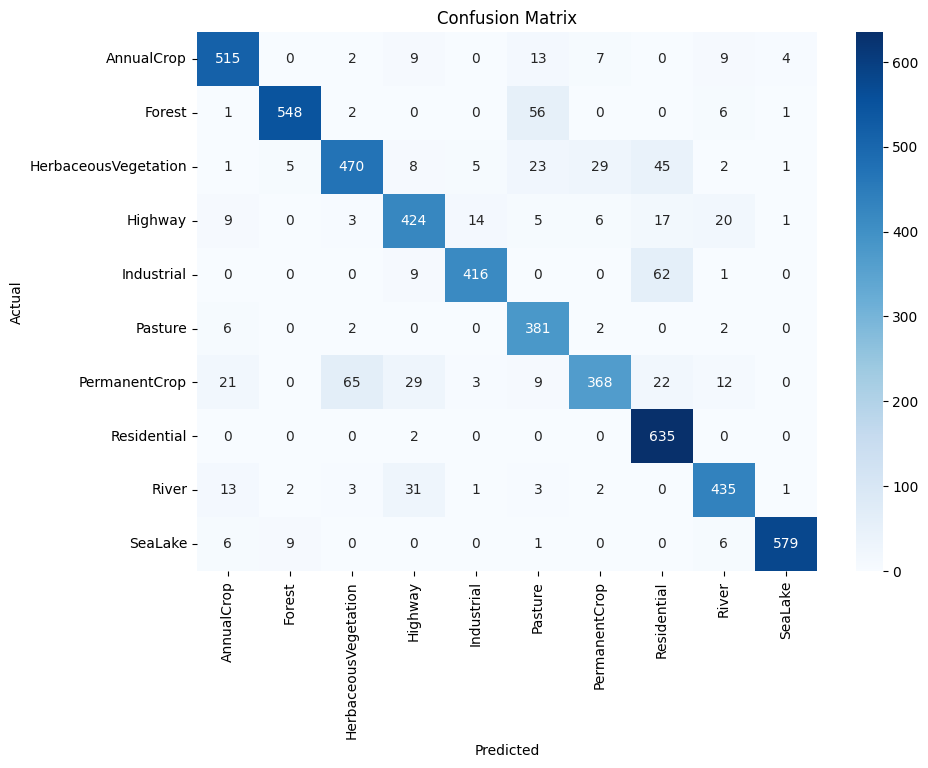

In [17]:
# Confusion Matrix
print("Confusion Matrix..")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [16]:
print("Classification Report...")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report...
                      precision    recall  f1-score   support

          AnnualCrop       0.90      0.92      0.91       559
              Forest       0.97      0.89      0.93       614
HerbaceousVegetation       0.86      0.80      0.83       589
             Highway       0.83      0.85      0.84       499
          Industrial       0.95      0.85      0.90       488
             Pasture       0.78      0.97      0.86       393
       PermanentCrop       0.89      0.70      0.78       529
         Residential       0.81      1.00      0.90       637
               River       0.88      0.89      0.88       491
             SeaLake       0.99      0.96      0.97       601

            accuracy                           0.88      5400
           macro avg       0.89      0.88      0.88      5400
        weighted avg       0.89      0.88      0.88      5400

